In [1]:
using Pkg
Pkg.activate("../../")

  Activating project at `d:\Projects\Dr. Heyl Group\ising-xy-distances-study`

In [2]:
using CairoMakie
include("../../src/spinmc.jl");

In [3]:
datapath = joinpath("d:\\", "Projects", "Dr. Heyl Group", "cluster_data")
println("datapath: "* datapath)
@assert ispath(datapath)

datapath: d:\Projects\Dr. Heyl Group\cluster_data

In [14]:
lattice_sizes = [32, 40, 48, 56, 64];
temps = [2.000, 2.100, 2.200, 2.210, 2.220, 2.230, 2.240, 2.250, 2.260, 2.270, 2.280, 2.290, 2.300, 2.310, 2.320, 2.330, 2.340, 2.350, 2.360, 2.370, 2.380, 2.390, 2.400, 2.500];

# Check magnetization of the system

In [15]:
mags, error_mags = let
    mags = zeros(Float64, (length(temps), length(lattice_sizes)))
    error_mags = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes)
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            m_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "mags", "ising_mags_temp$(T)_L$(L).txt"), ',')[:, 1]
            mags[stepT, stepL] = mean(m_arr) / L^2
            error_mags[stepT, stepL] = bootstrap_err(m_arr, mean) / L^2
        end
    end
    mags, error_mags
end;

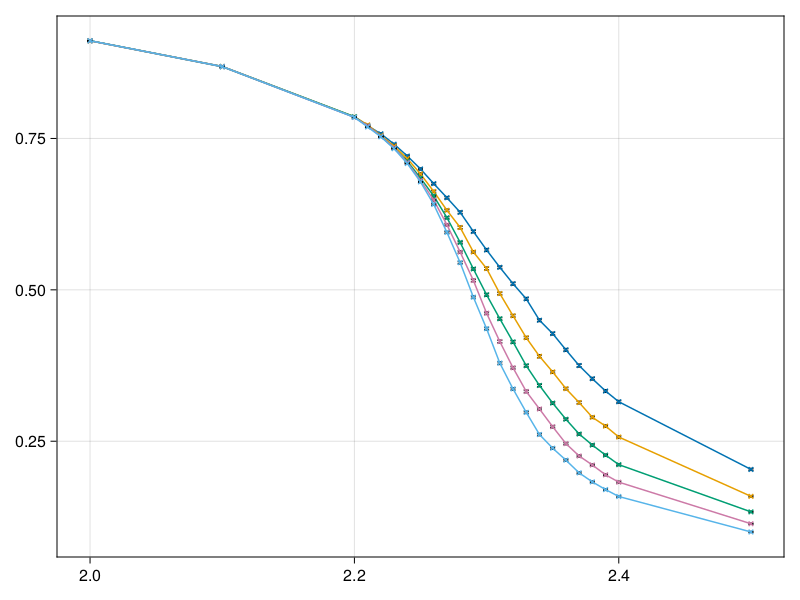

In [16]:
f1 = Figure()
ax1 = Axis(f1[1,1])

for idx=1:size(mags, 2)
    col = @view mags[:, idx]
    err = @view error_mags[:, idx]
    errorbars!(ax1, temps, col, err, whiskerwidth=5)
    scatterlines!(ax1, temps, col, marker=:xcross)
end
f1

# Structure factors

In [17]:
struc_facs, error_struc_facs = let
    struc_facs = zeros(Float64, (length(temps), length(lattice_sizes)))
    error_struc_facs = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes)
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            s_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "struc_facs", "ising_struc_facs_temp$(T)_L$(L).txt"), ',')[:, 1]
            struc_facs[stepT, stepL] = mean(s_arr)
            error_struc_facs[stepT, stepL] = bootstrap_err(s_arr, mean)
        end
    end
    struc_facs, error_struc_facs
end;

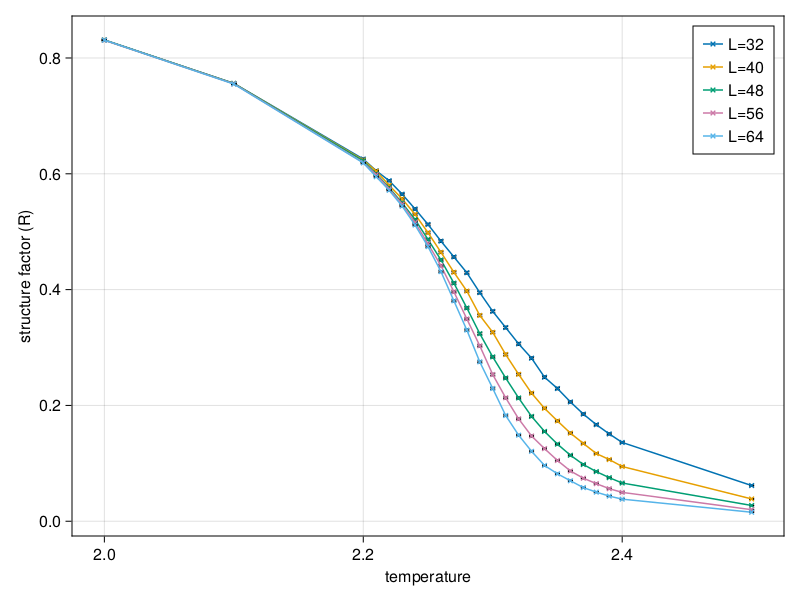

In [18]:
f2 = Figure()
ax2 = Axis(f2[1,1], xlabel="temperature", ylabel="structure factor (R)")

for idx=1:size(struc_facs, 2)
    col = @view struc_facs[:, idx]
    err = @view error_struc_facs[:, idx]
    errorbars!(ax2, temps, col, err, whiskerwidth=5)
    scatterlines!(ax2, temps, col, marker=:xcross, label="L=$(lattice_sizes[idx])")
end
axislegend(ax2, position=:rt)
# save("mean-sf-plot.pdf", f2)
f2

# FNN Distances

In [19]:
fnn_dists, error_fnn_dists = let
    fnn_dists = zeros(Float64, (length(temps), length(lattice_sizes)))
    error_fnn_dists = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes[1:end])
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            f_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "fnn_dists", "ising_fnn_dists_temp$(T)_L$(L).txt"), ',')[:, 1]
            fnn_dists[stepT, stepL] = mean(f_arr)
            error_fnn_dists[stepT, stepL] = bootstrap_err(f_arr, mean)
        end
    end
    fnn_dists, error_fnn_dists
end;

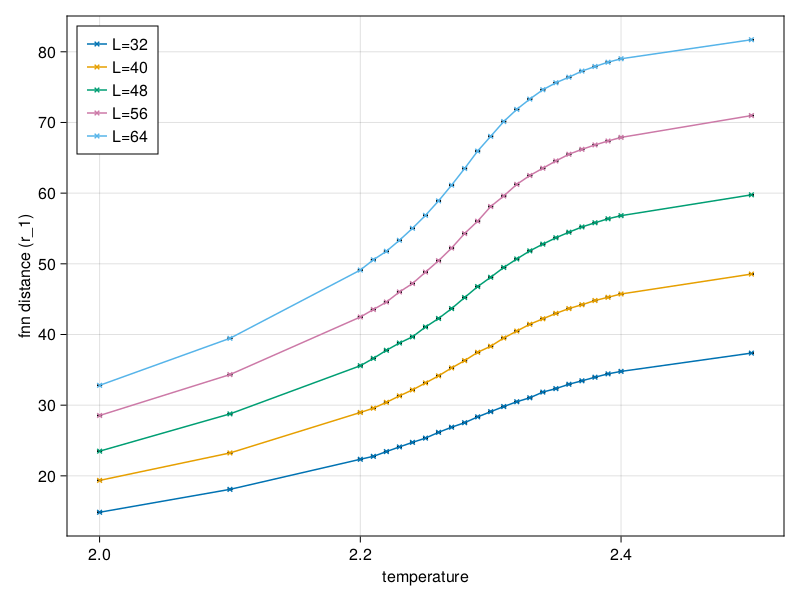

In [20]:
f3 = Figure()
ax3 = Axis(f3[1,1], xlabel="temperature", ylabel="fnn distance (r_1)")

for idx=1:size(fnn_dists, 2)
    col = @view fnn_dists[:, idx]
    err = @view error_fnn_dists[:, idx]
    errorbars!(ax3, temps, col, err, whiskerwidth=5)
    scatterlines!(ax3, temps, col,  marker=:xcross, label="L=$(lattice_sizes[idx])")
end
axislegend(ax3, position=:lt)
# save("mean-fnn-plot.pdf", f3)
f3

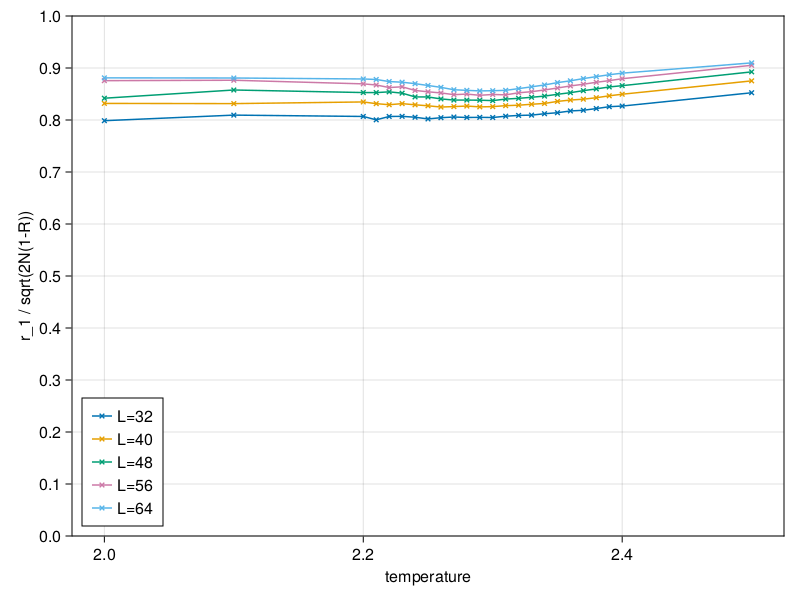

In [21]:
f4 = Figure()
ax4 = Axis(f4[1, 1], xlabel="temperature", ylabel="r_1 / sqrt(2N(1-R))")

for idx in eachindex(lattice_sizes)
    dists = @view fnn_dists[:, idx]
    sfs = @view struc_facs[:, idx]
    L = lattice_sizes[idx]
    qty = dists ./ sqrt.(2L^2 .* (1 .- sfs))
    scatterlines!(ax4, temps, qty, marker=:xcross, label="L=$(lattice_sizes[idx])")
end
ax4.yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ylims!(ax4, 0, 1)
axislegend(ax4, position=:lb)
# save("mean-fnn-scaled-plot.pdf", f4)
f4

# FNN Distances and Structure Factors correlation

In [22]:
fnn_sf_corr= let
    fnn_sf_corr = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes[1:end])
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            f_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "fnn_dists", "ising_fnn_dists_temp$(T)_L$(L).txt"), ',')[:, 1]
            s_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "struc_facs", "ising_struc_facs_temp$(T)_L$(L).txt"), ',')[:, 1]
            fnn_sf_corr[stepT, stepL] = cov(f_arr, s_arr)
        end
    end
    fnn_sf_corr
end;

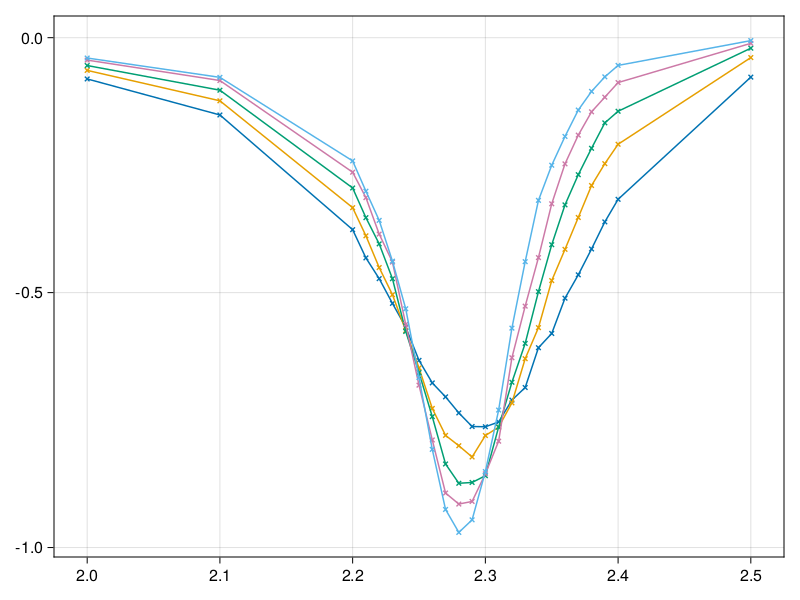

In [23]:
f5 = Figure()
ax5 = Axis(f5[1,1])

for idx in eachindex(lattice_sizes)
    c = @view fnn_sf_corr[:, idx]
    L = lattice_sizes[idx]
    scatterlines!(ax5, temps, c, marker=:xcross)
end
ax5.xticks = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
f5